In [15]:
import os
import gc
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm.notebook import tqdm

In [16]:
pd.set_option('display.max_colwidth', None)

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Load and Split Data

In [17]:
data = pd.read_json(os.path.join("advanced", "vlm.jsonl"), lines=True)

# build unique classes in dataset
id2label = ["background", "missile", "aircraft", "helicopter", "fighter", "drone", "others"]
label2id = {}
for idx, label in enumerate(id2label):
    label2id[label] = idx
print(len(id2label))
id2label[6]

7


'others'

In [18]:
data_splits = {}
data_splits["train"], data_splits["val"] = random_split(data.to_dict(orient="index"), [0.8, 0.2])
# data_splits["train"][0]

In [19]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        num = random.randint(5, 100)
        
        if num % 5 == 0:
            return tensor + torch.randn(tensor.size()) * self.std + self.mean
        
        return tensor
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [20]:
transforms = {
    "train": T.Compose([
        T.Resize(224),
        T.ToTensor(),
        T.Normalize([0.4986, 0.5428, 0.5563], [0.2721, 0.2717, 0.3078]),
        # AddGaussianNoise(0., 1.)
    ]),
    "valid": T.Compose([
        T.Resize(224),
        T.ToTensor(),
        T.Normalize([0.4986, 0.5428, 0.5563], [0.2721, 0.2717, 0.3078]),
        # AddGaussianNoise(0., 1.)
    ])
}

In [21]:
class VLMDataset(Dataset):
    def __init__(self, data, label2id, id2label, transform=None):   
        self.data = pd.DataFrame([row for row in data])
        self.label2id = label2id
        self.id2label = id2label
        self.transform = transform

        # extract features
        self.img_paths = self.data["image"].apply(lambda file: os.path.join("advanced", "images", file + ""))
        self.img_bboxes = self.data["annotations"].apply(lambda annos: [anno["bbox"] for anno in annos])
        self.img_labels = []
        for annos in self.data["annotations"]:
            labels = []

            for anno in annos:
                words = anno["caption"].split(" ")
                label = None
                
                for word in words:
                    if word in self.label2id.keys():
                        label = self.label2id[word]
                        
                if label is None:
                    label = self.label2id["others"]
                
                labels.append(label)
                    
            self.img_labels.append(labels)
                
    def __getitem__(self, idx):
        # load image standardized to RGB and transform image
        img = Image.open(self.img_paths[idx]).convert("RGB")
        img_wh = img.size
        
        if self.transform:
            img = self.transform(img)
            
            # get resize scale 
            x_scale = img.shape[2] / img_wh[0]
            y_scale = img.shape[1] / img_wh[1]
            
            # get resized bboxes
            bboxes = []
            for bbox in self.img_bboxes[idx]:
                x, y, w, h = bbox
                x1, y1, x2, y2 = x, y, x + w, y + h
                resized_bbox = [int(x1 * x_scale), int(y1 * y_scale), int(x2 * x_scale), int(y2 * y_scale)]
                bboxes.append(resized_bbox)

        # populate target with ground truths
        target = {
            "boxes": torch.as_tensor(bboxes),
            "labels": torch.as_tensor(self.img_labels[idx])
        }

        return img, target

    def __len__(self):
        return len(self.img_paths)
    
    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        
        if worker_info is None:
            return map(self.__getitem__, range(self.__len__()))

        per_worker = int(math.ceil((self.__len__()) / float(worker_info.num_workers)))
        worker_id = worker_info.id
        iter_start = worker_id * per_worker
        iter_end = min(iter_start + per_worker, self.__len__())
        return map(self.__getitem__, range(iter_start, iter_end))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0       advanced/images/image_4040.jpg
1       advanced/images/image_3948.jpg
2       advanced/images/image_1578.jpg
3       advanced/images/image_3185.jpg
4       advanced/images/image_3172.jpg
                     ...              
4081    advanced/images/image_1738.jpg
4082    advanced/images/image_3977.jpg
4083    advanced/images/image_1353.jpg
4084    advanced/images/image_1175.jpg
4085    advanced/images/image_4862.jpg
Name: image, Length: 4086, dtype: object
0        advanced/images/image_489.jpg
1       advanced/images/image_1898.jpg
2       advanced/images/image_1785.jpg
3       advanced/images/image_2988.jpg
4       advanced/images/image_4201.jpg
                     ...              
1016     advanced/images/image_243.jpg
1017    advanced/images/image_4495.jpg
1018    advanced/images/image_4478.jpg
1019    advanced/images/image_3027.jpg
1020     advanced/images/image_930.jpg
Name: image, Length: 1021, dtype: object


(tensor([[[0.7474, 0.7330, 0.7041,  ..., 0.9491, 0.9347, 0.9347],
          [0.7474, 0.7474, 0.7474,  ..., 0.9491, 0.9491, 0.9491],
          [0.7474, 0.7330, 0.7330,  ..., 0.9636, 0.9491, 0.9491],
          ...,
          [0.7474, 0.7618, 0.7906,  ..., 0.6609, 0.6753, 0.7041],
          [0.7330, 0.7474, 0.7906,  ..., 0.6321, 0.6609, 0.6897],
          [0.7330, 0.7330, 0.7618,  ..., 0.6897, 0.6753, 0.6465]],
 
         [[0.7301, 0.7157, 0.6868,  ..., 0.8745, 0.8745, 0.8745],
          [0.6868, 0.6868, 0.6868,  ..., 0.8600, 0.8600, 0.8745],
          [0.6724, 0.6724, 0.6580,  ..., 0.8600, 0.8600, 0.8889],
          ...,
          [0.7301, 0.7301, 0.7301,  ..., 0.6724, 0.6868, 0.6868],
          [0.7157, 0.7301, 0.7301,  ..., 0.6435, 0.6580, 0.6868],
          [0.7157, 0.7157, 0.7157,  ..., 0.6724, 0.6724, 0.6580]],
 
         [[0.7280, 0.7280, 0.7153,  ..., 0.8809, 0.8809, 0.8809],
          [0.7280, 0.7408, 0.7408,  ..., 0.8555, 0.8682, 0.8809],
          [0.7280, 0.7280, 0.7153,  ...,

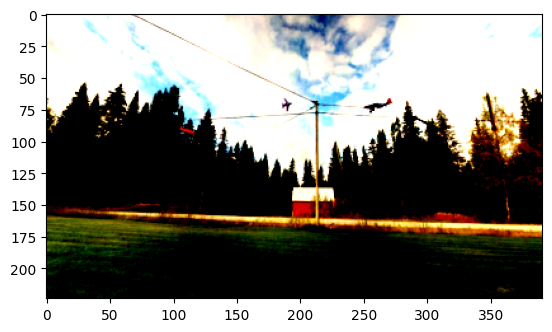

In [22]:
datasets = {
    "train": VLMDataset(data_splits["train"], label2id, id2label, transform=transforms["valid"]),
    "val": VLMDataset(data_splits["val"], label2id, id2label, transform=transforms["valid"]),
}
plt.imshow(datasets["train"][104][0].permute(1, 2, 0))
print(datasets["train"].img_paths)
print(datasets["val"].img_paths)
datasets["train"][0]

In [23]:
# imgs = torch.stack([img for img, target in datasets["train"]])

# mean = torch.mean(imgs, dim=(0, 2, 3))
# std = torch.std(imgs, dim=(0, 2, 3))
# print(mean)
# print(std)

# Training

In [24]:
class VLMModelWrapper:
    def __init__(self, model, n_classes, device="cpu", weights=None, optimizer=None, scheduler=None, epochs=None, save_dir=None):
        self.model = model
        self.device = device
        self.n_classes = n_classes
        self.weights = weights
        self.config_model(n_classes, weights)
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.epochs = epochs
        self.save_dir = save_dir

        # store losses for plotting
        self.train_losses = []
        self.val_losses = []

    def config_model(self, out_classes, weights):
        # configurate last layer of bbox predictor
        in_feats_bbox = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_feats_bbox, out_classes)

        if weights is not None:
            self.model.load_state_dict(weights)

        self.model.to(self.device)

    def fit(self, train_loader, val_loader):
        if self.epochs is None or self.optimizer is None:
            raise ValueError("Missing parameters \"epochs/optimizer\"")

        best_epoch = None
        best_loss = None

        for epoch in range(self.epochs):
            print(f"---------- Epoch {epoch}/{self.epochs - 1} ----------")

            train_loss = self.train(train_loader)
            if self.scheduler:
                self.scheduler.step()
            val_loss = self.validate(val_loader)

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            print(f"\nTrain Loss: {train_loss}")
            print(f"Validation Loss: {val_loss}")

            if best_loss is None or best_loss > val_loss:
                print(f"Best Epoch Validation Loss: {best_loss} -> {val_loss}")
                best_epoch = epoch
                best_loss = val_loss
                best_weights = self.model.state_dict()

                # save model checkpoints just in case
                if not os.path.exists(self.save_dir):
                    os.makedirs(self.save_dir)

                torch.save(best_weights, os.path.join(self.save_dir, "cp_model.pt"))
                
            print("")
            
        return best_epoch, best_loss, best_weights

    def train(self, dataloader):
        # set model to training mode
        self.model.train()

        avg_loss = 0

        for batch in tqdm(dataloader):
            imgs = batch[0].to(self.device)
            targets = [{k: v.to(self.device) for k, v in t.items() if k != "image_id"} for t in batch[1]]
            outputs = self.model(imgs, targets)

            # get the average loss of the classifier, bbox predictor, mask predictor
            loss = sum(l for l in outputs.values())
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            avg_loss += loss.detach()

        return avg_loss / len(dataloader)

    def validate(self, dataloader):
        # set model to train mode to retrieve losses, but do not calculate gradients
        self.model.train()

        avg_loss = 0

        # do not record computations for computing the gradient
        with torch.no_grad():
            for batch in tqdm(dataloader):
                imgs = batch[0].to(self.device)
                targets = [{k: v.to(self.device) for k, v in t.items() if k != "image_id"} for t in batch[1]]

                outputs = self.model(imgs, targets)

                # get the average loss of the classifier, bbox predictor, mask predictor
                loss = sum(l for l in outputs.values())
                avg_loss += loss.detach()

        return avg_loss / len(dataloader)

In [25]:
def collate_fn(batch):
    imgs = torch.stack([img for img, target in batch])
    targets = [target for img, target in batch]
    return [imgs, targets]

In [40]:
# configuations
save_dir = os.path.join("models", "rcnn")
device = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = len(id2label)
epochs = 30
batch_size = 4
lr = 1e-3
wd = 0.0001
# step_size = 5
# gamma = 0.1

In [41]:
dataloaders = {
    "train": DataLoader(datasets["train"], batch_size=batch_size, shuffle=True, collate_fn=collate_fn),
    "val": DataLoader(datasets["val"], batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
}

In [42]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")

optimizer = torch.optim.AdamW(
    params=[p for p in model.parameters() if p.requires_grad],
    lr=lr,
    weight_decay=wd
)

# scheduler = torch.optim.lr_scheduler.StepLR(
#     optimizer, 
#     step_size=step_size, 
#     gamma=gamma
# )

model_wrapper = VLMModelWrapper(
    model=model,
    n_classes=n_classes,
    device=device,
    optimizer=optimizer,
    # scheduler=scheduler,
    weights=torch.load(os.path.join("models", "rcnn", "checkpoint_nonoise_7c.pt"), map_location=device),
    epochs=epochs,
    save_dir=os.path.join(save_dir)
)

torch.cuda.empty_cache() if device == "cuda" else None
epoch, loss, weights = model_wrapper.fit(train_loader=dataloaders["train"], val_loader=dataloaders["val"])

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

print(f"Saving best model...")
torch.save(weights, os.path.join(save_dir, "best_model.pt"))

---------- Epoch 0/29 ----------


  0%|          | 0/1022 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]


Train Loss: 0.32657429575920105
Validation Loss: 0.31827396154403687
Best Epoch Validation Loss: None -> 0.31827396154403687

---------- Epoch 1/29 ----------


  0%|          | 0/1022 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]


Train Loss: 0.3255326747894287
Validation Loss: 0.31870752573013306

---------- Epoch 2/29 ----------


  0%|          | 0/1022 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]


Train Loss: 0.32452964782714844
Validation Loss: 0.3167949914932251
Best Epoch Validation Loss: 0.31827396154403687 -> 0.3167949914932251

---------- Epoch 3/29 ----------


  0%|          | 0/1022 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]


Train Loss: 0.32392817735671997
Validation Loss: 0.3162993788719177
Best Epoch Validation Loss: 0.3167949914932251 -> 0.3162993788719177

---------- Epoch 4/29 ----------


  0%|          | 0/1022 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]


Train Loss: 0.3231555223464966
Validation Loss: 0.3168044984340668

---------- Epoch 5/29 ----------


  0%|          | 0/1022 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]


Train Loss: 0.32260358333587646
Validation Loss: 0.3159230649471283
Best Epoch Validation Loss: 0.3162993788719177 -> 0.3159230649471283

---------- Epoch 6/29 ----------


  0%|          | 0/1022 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]


Train Loss: 0.32212039828300476
Validation Loss: 0.3154822587966919
Best Epoch Validation Loss: 0.3159230649471283 -> 0.3154822587966919

---------- Epoch 7/29 ----------


  0%|          | 0/1022 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]


Train Loss: 0.3215405344963074
Validation Loss: 0.31548336148262024

---------- Epoch 8/29 ----------


  0%|          | 0/1022 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]


Train Loss: 0.3211691677570343
Validation Loss: 0.3151049017906189
Best Epoch Validation Loss: 0.3154822587966919 -> 0.3151049017906189

---------- Epoch 9/29 ----------


  0%|          | 0/1022 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]


Train Loss: 0.32083940505981445
Validation Loss: 0.31508922576904297
Best Epoch Validation Loss: 0.3151049017906189 -> 0.31508922576904297

---------- Epoch 10/29 ----------


  0%|          | 0/1022 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]


Train Loss: 0.3206726908683777
Validation Loss: 0.3149280548095703
Best Epoch Validation Loss: 0.31508922576904297 -> 0.3149280548095703

---------- Epoch 11/29 ----------


  0%|          | 0/1022 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Hyperparameter Tuning

In [12]:
# configuations
save_dir = os.path.join("models", "rcnn")
device = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = len(id2label)
epochs = 5
batch_size = 4
lrates = [1e-1, 1e-5]
wdecays = [0.1, 0.0001]

In [14]:
best_model = {"lrate": None, "wdecay": None, "epoch": None, "loss": None, "weights": None}

for lr in lrates:
    for wd in wdecays:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")

        optimizer = torch.optim.Adam(
            params=[p for p in model.parameters() if p.requires_grad],
            lr=lr,
            weight_decay=wd
        )

        model_wrapper = VLMModelWrapper(
            model=model,
            n_classes=n_classes,
            device=device,
            optimizer=optimizer,
            epochs=epochs,
            save_dir=os.path.join(save_dir, f"{lr}_{wd}")
        )

        torch.cuda.empty_cache() if device == "cuda" else None
        epoch, loss, weights = model_wrapper.fit(train_loader=dataloaders["train"], val_loader=dataloaders["val"])

        if best_model["loss"] is None or best_model["loss"] > loss:
            best_model["lrate"] = lr
            best_model["wdecay"] = wd
            best_model["epoch"] = epoch
            best_model["loss"] = loss
            best_model["weights"] = weights

"""
    Plot and save train and validation loss curves, and save model weights
"""
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

print(f"Saving best model... Learning Rate:{best_model['lrate']} Weight Decay:{best_model['wdecay']})")
torch.save(best_model["weights"], os.path.join(save_dir, "best_model.pt"))

---------- Epoch 0/4 ----------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


Train Loss: 89.21988677978516
Validation Loss: 5.04832649230957
Best Epoch Validation Loss: None -> 5.04832649230957

---------- Epoch 1/4 ----------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


Train Loss: 3.4920170307159424
Validation Loss: 41.109500885009766

---------- Epoch 2/4 ----------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


Train Loss: 8.163403511047363
Validation Loss: 1.0698988437652588
Best Epoch Validation Loss: 5.04832649230957 -> 1.0698988437652588

---------- Epoch 3/4 ----------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


Train Loss: 0.866011917591095
Validation Loss: 0.725734531879425
Best Epoch Validation Loss: 1.0698988437652588 -> 0.725734531879425

---------- Epoch 4/4 ----------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


Train Loss: 1.266724944114685
Validation Loss: 2.6185171604156494

---------- Epoch 0/4 ----------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


Train Loss: 74.12938690185547
Validation Loss: 0.4345628619194031
Best Epoch Validation Loss: None -> 0.4345628619194031

---------- Epoch 1/4 ----------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


Train Loss: 0.42031389474868774
Validation Loss: 0.3592747449874878
Best Epoch Validation Loss: 0.4345628619194031 -> 0.3592747449874878

---------- Epoch 3/4 ----------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


Train Loss: 0.3646705150604248
Validation Loss: 0.3515918552875519
Best Epoch Validation Loss: 0.3592747449874878 -> 0.3515918552875519

---------- Epoch 4/4 ----------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


Train Loss: 4.676632404327393
Validation Loss: 29.337228775024414

---------- Epoch 0/4 ----------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


Train Loss: 1.2093513011932373
Validation Loss: 0.9770352840423584
Best Epoch Validation Loss: None -> 0.9770352840423584

---------- Epoch 1/4 ----------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


Train Loss: 0.8122138977050781
Validation Loss: 0.729213535785675
Best Epoch Validation Loss: 0.9770352840423584 -> 0.729213535785675

---------- Epoch 2/4 ----------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


Train Loss: 0.62714684009552
Validation Loss: 0.6423860192298889
Best Epoch Validation Loss: 0.729213535785675 -> 0.6423860192298889

---------- Epoch 3/4 ----------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


Train Loss: 0.5485883355140686
Validation Loss: 0.5783892869949341
Best Epoch Validation Loss: 0.6423860192298889 -> 0.5783892869949341

---------- Epoch 4/4 ----------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


Train Loss: 0.4774242639541626
Validation Loss: 0.554311990737915
Best Epoch Validation Loss: 0.5783892869949341 -> 0.554311990737915

---------- Epoch 0/4 ----------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


Train Loss: 1.083445429801941
Validation Loss: 0.8265278935432434
Best Epoch Validation Loss: None -> 0.8265278935432434

---------- Epoch 1/4 ----------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


Train Loss: 0.6398369669914246
Validation Loss: 0.5960643887519836
Best Epoch Validation Loss: 0.8265278935432434 -> 0.5960643887519836

---------- Epoch 2/4 ----------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


Train Loss: 0.4773908853530884
Validation Loss: 0.5137072801589966
Best Epoch Validation Loss: 0.5960643887519836 -> 0.5137072801589966

---------- Epoch 3/4 ----------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


Train Loss: 0.3910793364048004
Validation Loss: 0.48407599329948425
Best Epoch Validation Loss: 0.5137072801589966 -> 0.48407599329948425

---------- Epoch 4/4 ----------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


Train Loss: 0.341224730014801
Validation Loss: 0.486219197511673

Saving best model... Learning Rate:0.1 Weight Decay:0.0001)
